In [1]:
%matplotlib inline

import sys
sys.path.insert(0, "../fl_sim/")

In [61]:
import glob
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (5,3)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from models import *
from models.gan import ResNetDiscriminator, StyleVectorizer
from data_funcs import *
from utils.logger import Logger
import utils.gan_utils as gan_utils

In [89]:
# RUN_PADPAF = "../outputs/id=padpaf-revision-adam-epoch/task=dacifar10-fedgan/lr=0.0002_0.04/seed=123/model/*"
# RUN_PADPAF = "../outputs/id=padpaf-revision-adam-epoch/task=dacifar10-fedgan/lr=0.0005_0.02/seed=123/model/*"
RUN_PADPAF = "../outputs/id=padpaf-revision-adam-epoch/task=dacifar10-fedgan/lr=0.0001_0.001/seed=123/model/*"

MODEL_PATHS = RUN_PADPAF

In [90]:
conditional = "conditional" in MODEL_PATHS

In [91]:
# model_paths = glob.glob("models/partial/normal/model_round*.pth.tar")
def get_round(model_path):
    return int(model_path[-11:-8])

model_paths = glob.glob(MODEL_PATHS)
# model_paths = sorted(model_paths, key=lambda pth: get_round(pth))  # sort by round
for p in model_paths: print(p)

../outputs/id=padpaf-revision-adam-epoch/task=dacifar10-fedgan/lr=0.0001_0.001/seed=123/model/model.pth.tar


## Init setting and model

In [92]:
classifier_is_linear = True  # else: 2-layer nn with relu

Logger.setup_logging("INFO", logfile="")
Logger()

image_size = 64
channels = 3

dataset_name = "dacifar10"
data_path = "../data/"
num_workers = 0
device = "cuda:0" if torch.cuda.is_available() else "cpu"
num_classes = 10

batch_size = 64
lr = 1e-2
epochs = 50
lr_gamma = 0.95

In [93]:
loader_kwargs = {}
if not device == 'cpu':
    loader_kwargs["num_workers"] = num_workers
    loader_kwargs["persistent_workers"] = num_workers > 0

In [94]:
_, test_dataset = load_data(dataset=dataset_name, path=data_path)

Files already downloaded and verified
Files already downloaded and verified


## Load test dataset

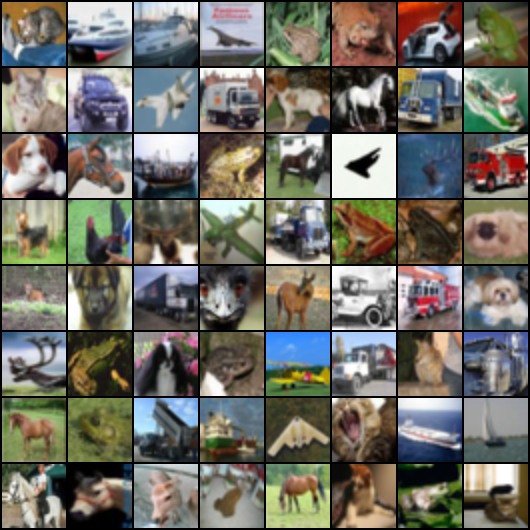

tensor([3, 8, 8, 0, 6, 6, 1, 6], device='cuda:0')
tensor([3, 1, 0, 9, 5, 7, 9, 8], device='cuda:0')
tensor([5, 7, 8, 6, 7, 0, 4, 9], device='cuda:0')
tensor([5, 2, 4, 0, 9, 6, 6, 5], device='cuda:0')
tensor([4, 5, 9, 2, 4, 1, 9, 5], device='cuda:0')
tensor([4, 6, 5, 6, 0, 9, 3, 9], device='cuda:0')
tensor([7, 6, 9, 8, 0, 3, 8, 8], device='cuda:0')
tensor([7, 7, 4, 6, 7, 3, 6, 3], device='cuda:0')


In [95]:
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, **loader_kwargs)
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    display(Image.fromarray(gan_utils.tensor_to_np(gan_utils.make_grid(0.5+0.5*x))))
    for i in range(0, y.size(0), 8):
        print(y[i:i+8])
    break

## Load model

In [96]:
def init_styleD(num_features=64):
     return ResNetDiscriminator(num_features=num_features, image_size=image_size, channels=channels)


def init_style_map(num_latents=128):
     return StyleVectorizer(num_latents, 8, lr_mul=0.1)


def init_model(num_latents=256, num_features=128):
    return FedGAN(num_latents=num_latents,
                             D_features=num_features, G_features=num_features, content_to_style_features=4,
                             image_size=image_size, channels=channels, num_classes=num_classes if conditional else 0)

global_model = init_model().to(device)

In [97]:
def moving_avg(series, t=1):
    return series
    ###
    avgs = []
    for i in range(1, len(series) + 1):
        last_t = series[:i][-t:]
        avg = sum(last_t) / len(last_t)
        avgs.append(avg)
    return avgs


def load_fedgan_one_style(global_model, fp, style_id=0, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'], strict=False)
    # Local modules
    local_state_dict = state_dict[str(style_id)]
    global_model.styleD.load_state_dict(local_state_dict['styleD'])
    global_model.style_map.load_state_dict(local_state_dict['style_map'])
    return global_model


def load_fedgan_all_styles(global_model, fp, device=None):
    state_dict = torch.load(fp, map_location=device)
    # Global modules
    global_model.contentD.load_state_dict(state_dict['contentD'])
    global_model.G.load_state_dict(state_dict['G'], strict=False)
    private_modules = []
    for worker_id in range(len(state_dict)):
        if str(worker_id) not in state_dict:
            continue
        # Local modules
        local_state_dict = state_dict[str(worker_id)]
        # TODO: can't we just deepcopy from global_model? (write copy() method)
        styleD = init_styleD().to(device)
        styleD.load_state_dict(local_state_dict['styleD'])
        style_map = init_style_map().to(device)
        style_map.load_state_dict(local_state_dict['style_map'])
        style_modules = {
            "id": worker_id,
            "styleD": styleD,
            "style_map": style_map,
        }
        private_modules.append(style_modules)
    return global_model, private_modules

## Train a linear classifier on content features and a one style features

In [98]:
classifier_name = 'linear_classifier' if classifier_is_linear else 'mlp_classifier'

def make_classifier(num_features, output_dim=num_classes, linear=classifier_is_linear):
    if linear:
        return nn.Linear(num_features, output_dim)
    else:
        return nn.Sequential(
            nn.Linear(num_features, num_features),
            nn.BatchNorm1d(num_features),
            nn.ReLU(),
            nn.Linear(num_features, output_dim),
        )

classifier_name

'linear_classifier'

In [99]:
global_model = load_fedgan_one_style(global_model, model_paths[-1], style_id=0, device=device)

In [100]:
content_classifier = make_classifier(global_model.contentD.hidden_dim).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

style_classifier = make_classifier(global_model.styleD.hidden_dim).to(device)
style_classifier_optim = torch.optim.Adam(style_classifier.parameters(), lr=lr)
style_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(style_classifier_optim, gamma=lr_gamma)

loss_fn = nn.CrossEntropyLoss().to(device)

print(sum(p.numel() for p in content_classifier.parameters()))

5130


In [101]:
content_losses = []
content_accs = []
style_losses = []
style_accs = []
for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    mean_style_loss = 0.0
    mean_style_acc = 0.0
    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            _, style_features = global_model.styleD(x, return_h=True)
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        style_pred = style_classifier(style_features)
        style_y = style_pred.max(dim=1).indices
        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        style_loss = loss_fn(style_pred, y)
        content_classifier_optim.zero_grad()
        style_classifier_optim.zero_grad()
        content_loss.backward()
        style_loss.backward()
        content_classifier_optim.step()
        style_classifier_optim.step()
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        style_acc = (style_y == y).sum() / y.size(0)
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        mean_style_loss += style_loss.item() / len(test_loader)
        mean_style_acc += style_acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    style_losses.append(mean_style_loss)
    style_accs.append(mean_style_acc)
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          f"style_loss = {mean_style_loss:4f}\t"
          f"style_acc = {mean_style_acc:4f}"
         )
    content_classifier_optim_sched.step()
    style_classifier_optim_sched.step()

[1/50] content_loss = 2.092868	content_acc = 0.252389	style_loss = 1.914191	style_acc = 0.313097
[2/50] content_loss = 1.762370	content_acc = 0.420084	style_loss = 1.730837	style_acc = 0.374602
[3/50] content_loss = 1.606053	content_acc = 0.477607	style_loss = 1.669698	style_acc = 0.397293
[4/50] content_loss = 1.511823	content_acc = 0.509256	style_loss = 1.630593	style_acc = 0.411923
[5/50] content_loss = 1.447155	content_acc = 0.530056	style_loss = 1.602374	style_acc = 0.421676
[6/50] content_loss = 1.399108	content_acc = 0.545979	style_loss = 1.580587	style_acc = 0.430932
[7/50] content_loss = 1.361489	content_acc = 0.554837	style_loss = 1.562959	style_acc = 0.437799
[8/50] content_loss = 1.330858	content_acc = 0.562699	style_loss = 1.548255	style_acc = 0.443471
[9/50] content_loss = 1.305244	content_acc = 0.570362	style_loss = 1.535700	style_acc = 0.447154
[10/50] content_loss = 1.283362	content_acc = 0.576433	style_loss = 1.524781	style_acc = 0.448945
[11/50] content_loss = 1.2643

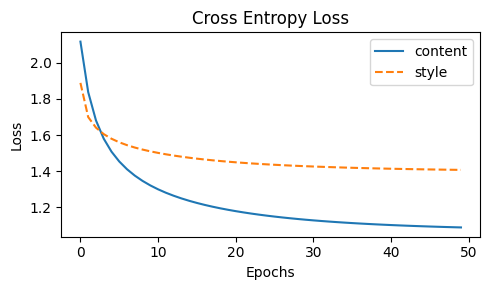

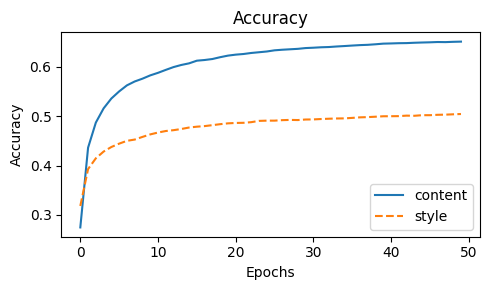

In [75]:
plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_losses)), label="style", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_one_style.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_accs)), label="style", linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_one_style.pdf")

## Train a classifier on all style features

In [25]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)
[m["id"] for m in private_modules]

[0, 1, 2, 3, 4, 5, 6, 7]

In [26]:
content_classifier = make_classifier(global_model.contentD.num_features).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

for m in private_modules:
    m["classifier"] = make_classifier(global_model.styleD.num_features).to(device)
    m["classifier_optim"] = torch.optim.Adam(m["classifier"].parameters(), lr=lr)
    m["classifier_optim_sched"] = torch.optim.lr_scheduler.ExponentialLR(m["classifier_optim"], gamma=lr_gamma)

loss_fn = nn.CrossEntropyLoss().to(device)

In [27]:
content_losses = []
content_accs = []
for m in private_modules:
    m["losses"] = []
    m["accs"] = []

for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    for m in private_modules:
        m["mean_loss"] = 0.0
        m["mean_acc"] = 0.0

    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            all_style_features = [m["styleD"](x, return_h=True)[1] for m in private_modules]
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        all_style_pred = [m["classifier"](f) for m, f in zip(private_modules, all_style_features)]
        all_style_y = [pred.max(dim=1).indices for pred in all_style_pred]
        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        all_style_loss = [loss_fn(pred, y) for pred in all_style_pred]
        content_classifier_optim.zero_grad()
        [m["classifier_optim"].zero_grad() for m in private_modules]
        content_loss.backward()
        [loss.backward() for loss in all_style_loss]
        content_classifier_optim.step()
        [m["classifier_optim"].step() for m in private_modules]
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        all_style_acc = [(style_y == y).sum() / y.size(0) for style_y in all_style_y]
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        for m, loss, acc in zip(private_modules, all_style_loss, all_style_acc):
            m["mean_loss"] += loss.item() / len(test_loader)
            m["mean_acc"] += acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    for m in private_modules:
        m["losses"].append(m["mean_loss"])
        m["accs"].append(m["mean_acc"])
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          + "\t".join(
              f"style[{m['id']}]_loss = {m['mean_loss']:4f}\t"
              f"style[{m['id']}]_acc = {m['mean_acc']:4f}"
              for m in private_modules
          )
         )
    content_classifier_optim_sched.step()
    [m["classifier_optim_sched"].step() for m in private_modules]

[1/50] content_loss = 0.837149	content_acc = 0.810304	style[0]_loss = 2.242249	style[0]_acc = 0.167432	style[1]_loss = 2.290345	style[1]_acc = 0.137181	style[2]_loss = 2.277318	style[2]_acc = 0.148163	style[3]_loss = 2.225122	style[3]_acc = 0.211562	style[4]_loss = 2.226882	style[4]_acc = 0.204872	style[5]_loss = 2.191709	style[5]_acc = 0.197484	style[6]_loss = 2.153227	style[6]_acc = 0.207967	style[7]_loss = 2.237788	style[7]_acc = 0.187700
[2/50] content_loss = 0.284644	content_acc = 0.937200	style[0]_loss = 2.198197	style[0]_acc = 0.200879	style[1]_loss = 2.250599	style[1]_acc = 0.179413	style[2]_loss = 2.224299	style[2]_acc = 0.192692	style[3]_loss = 2.090625	style[3]_acc = 0.287640	style[4]_loss = 2.156717	style[4]_acc = 0.252496	style[5]_loss = 2.112485	style[5]_acc = 0.247604	style[6]_loss = 2.073969	style[6]_acc = 0.244708	style[7]_loss = 2.153526	style[7]_acc = 0.240216
[3/50] content_loss = 0.209404	content_acc = 0.948982	style[0]_loss = 2.169133	style[0]_acc = 0.225539	style

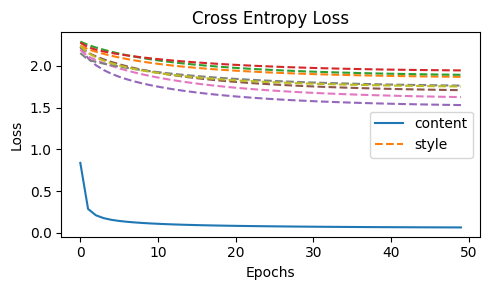

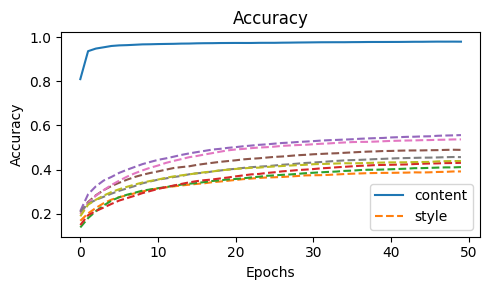

In [28]:
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C0', linestyle='solid',  label='content'),
                   Line2D([0], [0], color='C1', linestyle='dashed', label='style')]

plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
for m in private_modules:
    plt.plot(np.array(moving_avg(m["losses"])), label=f"style{m['id']}", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(handles=legend_elements)
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_all_styles.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content", linestyle='solid')
for m in private_modules:
    plt.plot(np.array(moving_avg(m["accs"])), label=f"style{m['id']}", linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(handles=legend_elements)
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_all_styles.pdf")

## Predict style

In [35]:
global_model, private_modules = load_fedgan_all_styles(global_model, model_paths[-1], device=device)

In [36]:
content_classifier = make_classifier(global_model.contentD.num_features, output_dim=len(private_modules)).to(device)
content_classifier_optim = torch.optim.Adam(content_classifier.parameters(), lr=lr)
content_classifier_optim_sched = torch.optim.lr_scheduler.ExponentialLR(content_classifier_optim, gamma=lr_gamma)

for m in private_modules:
    m["classifier"] = make_classifier(global_model.styleD.num_features, output_dim=1).to(device)
    m["classifier_optim"] = torch.optim.Adam(m["classifier"].parameters(), lr=lr)
    m["classifier_optim_sched"] = torch.optim.lr_scheduler.ExponentialLR(m["classifier_optim"], gamma=lr_gamma)

style_linear = make_classifier(len(private_modules), output_dim=len(private_modules)).to(device)
style_linear_optim = torch.optim.Adam(style_linear.parameters(), lr=lr)

loss_fn = nn.CrossEntropyLoss().to(device)

print(sum(p.numel() for p in content_classifier.parameters()))

520


In [37]:
content_losses = []
content_accs = []
style_losses = []
style_accs = []

for epoch in range(epochs):
    mean_content_loss = 0.0
    mean_content_acc = 0.0
    mean_style_loss = 0.0
    mean_style_acc = 0.0

    for i, (x, y) in enumerate(test_loader):

        y = torch.randint(0, len(private_modules), (batch_size,)).to(device)  # y is the client now
        x_list = []
        for i in y:
            global_latent = torch.randn(1, global_model.num_latents).to(device)
            style_latent = torch.randn(1, global_model.num_latents).to(device)
            style = private_modules[i]["style_map"](style_latent)
            label = torch.randint(0, num_classes, (1,)).to(device).int() if conditional else None
            xi = global_model.G(global_latent, cond=style, label=label)
            x_list.append(xi)
        x = torch.cat(x_list, dim=0)

        # y = torch.randint(0, len(private_modules), (1,)).repeat(batch_size).to(device)
        # client = y[0].item()
        # global_latent = torch.randn(batch_size, global_model.num_latents).to(device)
        # style_latent = torch.randn(batch_size, global_model.num_latents).to(device)
        # style = private_modules[client]["style_map"](style_latent)
        # label = torch.randint(0, num_classes, (batch_size,)).to(device).int() if conditional else None
        # x = global_model.G(global_latent, cond=style, label=label)

        # Get features from discriminators
        with torch.no_grad():
            _, content_features = global_model.contentD(x, return_h=True)
            all_style_features = [m["styleD"](x, return_h=True)[1] for m in private_modules]
        # Get predictions from classifiers
        content_pred = content_classifier(content_features)
        content_y = content_pred.max(dim=1).indices
        # stack predictions, get maximum out of all stacks per entry, then get maximum entry (i.e. get max probability)
        style_pred = torch.stack([m["classifier"](f) for m, f in zip(private_modules, all_style_features)], dim=1).squeeze()
        style_pred = style_linear(style_pred)
        style_y = style_pred.max(dim=1).indices

        # Calculate loss and optimize
        content_loss = loss_fn(content_pred, y)
        style_loss = loss_fn(style_pred, y)
        content_classifier_optim.zero_grad()
        style_linear_optim.zero_grad()
        [m["classifier_optim"].zero_grad() for m in private_modules]
        content_loss.backward()
        style_loss.backward()
        content_classifier_optim.step()
        style_linear_optim.step()
        [m["classifier_optim"].step() for m in private_modules]
        # Calculate accuracies
        content_acc = (content_y == y).sum() / y.size(0)
        style_acc = (style_y == y).sum() / y.size(0)
        # accumulate mean losses and accs
        mean_content_loss += content_loss.item() / len(test_loader)
        mean_content_acc += content_acc.item() / len(test_loader)
        mean_style_loss += style_loss.item() / len(test_loader)
        mean_style_acc += style_acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    content_losses.append(mean_content_loss)
    content_accs.append(mean_content_acc)
    style_losses.append(mean_style_loss)
    style_accs.append(mean_style_acc)
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          f"content_loss = {mean_content_loss:4f}\t"
          f"content_acc = {mean_content_acc:4f}\t"
          f"style_loss = {mean_style_loss:4f}\t"
          f"style_acc = {mean_style_acc:4f}\t"
         )
    content_classifier_optim_sched.step()
    [m["classifier_optim_sched"].step() for m in private_modules]

[1/50] content_loss = 1.317177	content_acc = 0.521765	style_loss = 0.808620	style_acc = 0.709964	
[2/50] content_loss = 0.920167	content_acc = 0.654153	style_loss = 0.492766	style_acc = 0.805511	
[3/50] content_loss = 0.800729	content_acc = 0.703275	style_loss = 0.453636	style_acc = 0.821785	
[4/50] content_loss = 0.736356	content_acc = 0.728934	style_loss = 0.422108	style_acc = 0.832768	
[5/50] content_loss = 0.702946	content_acc = 0.735024	style_loss = 0.409865	style_acc = 0.837560	
[6/50] content_loss = 0.663823	content_acc = 0.753095	style_loss = 0.369488	style_acc = 0.857228	
[7/50] content_loss = 0.626783	content_acc = 0.765675	style_loss = 0.346619	style_acc = 0.862320	
[8/50] content_loss = 0.618130	content_acc = 0.767372	style_loss = 0.345472	style_acc = 0.867712	
[9/50] content_loss = 0.602658	content_acc = 0.776458	style_loss = 0.328172	style_acc = 0.873702	
[10/50] content_loss = 0.600350	content_acc = 0.774261	style_loss = 0.320407	style_acc = 0.874101	
[11/50] content_los

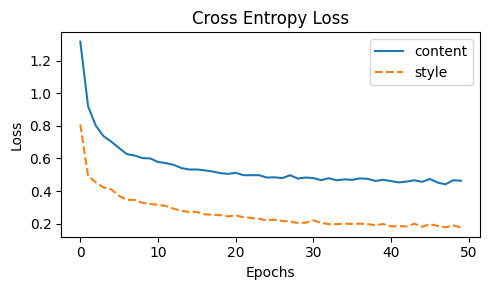

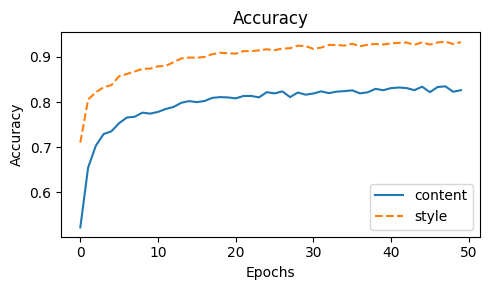

In [42]:
from matplotlib.lines import Line2D

plt.figure()
plt.plot(np.array(moving_avg(content_losses)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_losses)), label="style", linestyle='dashed')
plt.title("Cross Entropy Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_predict_style.pdf")

plt.figure()
plt.plot(np.array(moving_avg(content_accs)), label="content", linestyle='solid')
plt.plot(np.array(moving_avg(style_accs)), label="style", linestyle='dashed')
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.tight_layout()
plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_predict_style.pdf")

# Check model's accuracy vs. comm rounds

In [34]:
global_models = {get_round(pth): load_fedgan_one_style(init_model().to(device), pth, device=device)
                 for pth in model_paths}
print(list(global_models.keys()))

[25, 50, 75, 100, 125, 150, 175, 200, 225]


In [35]:
trainers = [{ "id": cr, "contentD": global_models[cr].contentD } for cr in global_models]

In [36]:
for m in trainers:
    m["classifier"] = make_classifier(m["contentD"].num_features).to(device)
    m["classifier_optim"] = torch.optim.Adam(m["classifier"].parameters(), lr=lr)
    m["classifier_optim_sched"] = torch.optim.lr_scheduler.ExponentialLR(m["classifier_optim"], gamma=lr_gamma)

loss_fn = nn.CrossEntropyLoss().to(device)

In [37]:
for m in trainers:
    m["losses"] = []
    m["accs"] = []

for epoch in range(epochs):
    for m in trainers:
        m["mean_loss"] = 0.0
        m["mean_acc"] = 0.0

    for i, (x, y) in enumerate(test_loader):
        x, y = x.to(device), y.to(device)
        # Get features from discriminators
        with torch.no_grad():
            all_features = [m["contentD"](x, return_h=True)[1] for m in trainers]
        # Get predictions from classifiers
        all_pred = [m["classifier"](f) for m, f in zip(trainers, all_features)]
        all_y = [pred.max(dim=1).indices for pred in all_pred]
        # Calculate loss and optimize
        all_loss = [loss_fn(pred, y) for pred in all_pred]
        [m["classifier_optim"].zero_grad() for m in trainers]
        [loss.backward() for loss in all_loss]
        [m["classifier_optim"].step() for m in trainers]
        # Calculate accuracies
        all_acc = [(y_hat == y).sum() / y.size(0) for y_hat in all_y]
        # accumulate mean losses and accs
        for m, loss, acc in zip(trainers, all_loss, all_acc):
            m["mean_loss"] += loss.item() / len(test_loader)
            m["mean_acc"] += acc.item() / len(test_loader)
    # Record epoch mean loss and acc
    for m in trainers:
        m["losses"].append(m["mean_loss"])
        m["accs"].append(m["mean_acc"])
    print(f"[{epoch+1}/{epochs}] "  #[{i+1}/{len(test_loader)}] "
          + "\t".join(
              f"model[{m['id']}]_loss = {m['mean_loss']:4f}\t"
              f"model[{m['id']}]_acc = {m['mean_acc']:4f}"
              for m in trainers
          )
         )
    [m["classifier_optim_sched"].step() for m in trainers]

[1/50] model[25]_loss = 1.474826	model[25]_acc = 0.662839	model[50]_loss = 1.119587	model[50]_acc = 0.766873	model[75]_loss = 1.060489	model[75]_acc = 0.774760	model[100]_loss = 0.963989	model[100]_acc = 0.802616	model[125]_loss = 0.925903	model[125]_acc = 0.800120	model[150]_loss = 0.870466	model[150]_acc = 0.821785	model[175]_loss = 0.840073	model[175]_acc = 0.819688	model[200]_loss = 0.878302	model[200]_acc = 0.806210	model[225]_loss = 0.875433	model[225]_acc = 0.799421
[2/50] model[25]_loss = 0.742173	model[25]_acc = 0.846346	model[50]_loss = 0.443610	model[50]_acc = 0.914537	model[75]_loss = 0.403855	model[75]_acc = 0.917232	model[100]_loss = 0.335138	model[100]_acc = 0.933506	model[125]_loss = 0.324677	model[125]_acc = 0.936701	model[150]_loss = 0.300409	model[150]_acc = 0.942292	model[175]_loss = 0.293565	model[175]_acc = 0.938399	model[200]_loss = 0.297842	model[200]_acc = 0.937300	model[225]_loss = 0.288296	model[225]_acc = 0.936402
[3/50] model[25]_loss = 0.543672	model[25]_a

In [38]:
# Aggregate data into one dataframe
dfs = []
for m in trainers:
    df = pd.DataFrame()
    df["loss"] = m["losses"]
    df["acc"] = m["accs"]
    df["comm_round"] = m["id"]
    df = df.reset_index()
    dfs.append(df)

data_df = pd.concat(dfs, ignore_index=True)
data_df = data_df.rename(columns={"index": "epoch"})
data_df

,epoch,loss,acc,comm_round
0,0,1.474826,0.662839,25
1,1,0.742173,0.846346,25
2,2,0.543672,0.875899,25
3,3,0.450302,0.891474,25
4,4,0.394564,0.901058,25
...,...,...,...,...
445,45,0.064981,0.979932,225
446,46,0.064670,0.980032,225
447,47,0.064374,0.979932,225
448,48,0.064093,0.980331,225


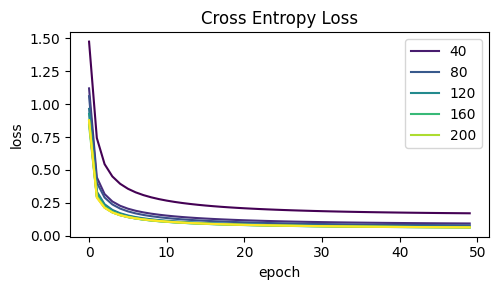

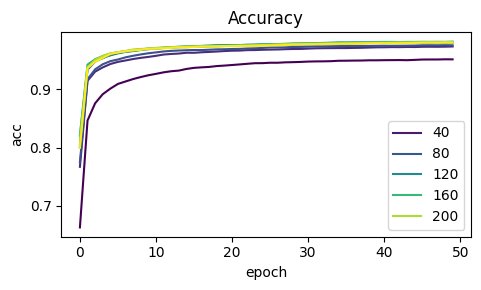

In [39]:
plt.figure()
sns.lineplot(x="epoch", y="loss", hue="comm_round", palette="viridis", data=data_df)
plt.title("Cross Entropy Loss")
plt.legend()
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_loss_all_rounds.pdf")

plt.figure()
sns.lineplot(x="epoch", y="acc", hue="comm_round", palette="viridis", data=data_df)
plt.title("Accuracy")
plt.legend()
plt.tight_layout()
# plt.savefig(f"results/{classifier_name}{'_cond' if conditional else ''}_acc_all_rounds.pdf")